In [20]:
import requests
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

key = ''  #Add your API Key from tankerkönig.de. See https://creativecommons.tankerkoenig.de/
url = 'https://creativecommons.tankerkoenig.de/json/'

url_new = f"{url}list.php"
params = {
    "apikey": key,
    "lat": 52.515087638402385,
    "lng": 13.40686979530763,
    "rad": 20,
    "type": 'all'
}

response = requests.get(url_new, params=params)
data = response.json()
df_normal = pd.json_normalize(data['stations'], max_level=1)
df_normal['date'] = pd.to_datetime(datetime.now())
df_normal['hour'] = df_normal['date'].dt.hour
df_normal['day'] = 3
df_normal['month'] = 3
df_normal['weekday'] = 1
df_normal['year'] = 2025
df_normal.drop(columns=['date'], inplace=True)
df_normal = df_normal.dropna()

encoder = LabelEncoder()
df_normal['station_id_encoded'] = encoder.fit_transform(df_normal['id'])

In [21]:
import numpy as np

# Compute cyclical features for the current hour
df_normal['hour_sin'] = np.sin(2 * np.pi * df_normal['hour'] / 24)
df_normal['hour_cos'] = np.cos(2 * np.pi * df_normal['hour'] / 24)

# For demonstration, we use the current E5 price as a placeholder for lag features and rolling averages.
# In a real scenario, merge with historical data to compute these accurately.
df_normal['e5_lag_1'] = df_normal['e5']
df_normal['e5_lag_3'] = df_normal['e5']
df_normal['e5_lag_7'] = df_normal['e5']
df_normal['e5_7d_avg'] = df_normal['e5']
df_normal['e5_volatility'] = 0.0  # Without historical changes, volatility is unknown

# Oil-related features should be obtained from your oil dataset or forecast.
# For now, we use placeholder values (e.g., the most recent known oil price).
placeholder_oil_price = 70.0  # example placeholder value
df_normal['oil_price'] = placeholder_oil_price
df_normal['oil_7d_avg'] = placeholder_oil_price

In [22]:
import joblib

# Load your trained model
model = joblib.load('models/xgbr_trained.pkl')

# Define the feature columns (make sure these match the model training)
feature_cols = ['hour_sin', 'hour_cos', 'station_id_encoded', 'e5_7d_avg',
                'oil_price', 'oil_7d_avg', 'e5_volatility', 'e5_lag_1',
                'e5_lag_3', 'e5_lag_7']

# Make predictions for each station in today's data
df_normal['predicted_e5'] = model.predict(df_normal[feature_cols])


In [23]:
from scipy.stats import pearsonr

# Calculate Pearson correlation between actual and predicted E5 prices
corr, p_value = pearsonr(df_normal['e5'], df_normal['predicted_e5'])
print("Pearson correlation:", corr)
print("P-value:", p_value)

Pearson correlation: 0.9674667293549281
P-value: 1.6678300360363316e-183


In [24]:
compare_df = pd.DataFrame({
    "ID": df_normal['id'],
    "Predicted e5": df_normal['predicted_e5'],
    "Actual e5": df_normal['e5'],
})
compare_df

,ID,Predicted e5,Actual e5
0,278130b1-e062-4a0f-80cc-19e486b4c024,1.784859,1.779
1,594eafdd-3537-45ae-8bf0-d667aaa25454,1.771862,1.759
2,813ed58c-b58d-4d17-895b-2078cb302649,1.809665,1.799
3,94e70fc4-b22f-4e5a-877f-bc1082cdae81,1.715955,1.719
4,448e4ee6-3404-4868-b7e6-ea59a5c78eb9,1.784859,1.779
...,...,...,...
304,34b4ac1b-77af-481c-88b5-237921f4eb7c,1.708074,1.699
305,cd8ba6a6-98cd-1ed7-9c96-62f66643d7be,1.725098,1.729
306,005056ba-7cb6-1ed2-bceb-662ba1a94d1f,1.962691,1.929
307,ce241717-83a0-1ee9-8194-53855ba71417,1.725098,1.729


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(df_normal['e5'], df_normal['predicted_e5'])
mse

0.0009676815129040317

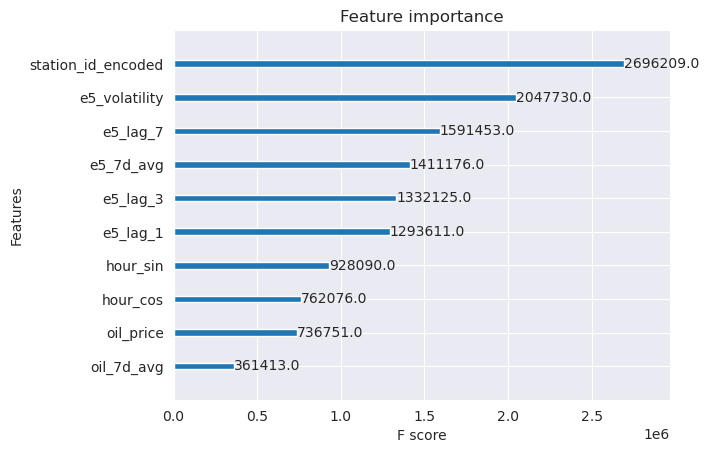

In [26]:
import xgboost as xgb
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()